<a href="https://colab.research.google.com/github/tikendraw/question-answering-squad-model/blob/main/question_answers_genration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question Answers Generations Model

In [1]:
import os, sys
if 'google.colab' in sys.modules:
    
    ! git clone https://github.com/tikendraw/question-answering-squad-model.git
    os.chdir('question-answering-squad-model') 
    print(os.getcwd())

if 'google.colab' in sys.modules:
    
    !pip install tensorflow-text -q
    ! pip install polars -q
    !pip install tensorflow_hub -q



    
    
# Dependencies

import tensorflow_hub as hub
import tensorflow_text as tf_text
import pandas as pd
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention, LSTM, Bidirectional, Dense, MaxPooling1D, Input, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
import json

print('Tf version: ',tf.__version__)
print('GPU: ', is_gpu:=len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if is_gpu:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(physical_devices)
    print(config)

def download_USEncoder():

    print('downloading universal sentence encoder...')
    !wget https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
    print('Downloaded universal sentence encoder.')
    # Extracting
    try:
        !mkdir universal_sentence_encoder
        print('Extracting universal sentence encoder....')
        ! tar -xf 4.tar.gz --directory ./universal_sentence_encoder
        print('Extracted.')
    except Exception as e:
        print(e)


2023-02-04 06:38:08.719899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 06:38:10.596181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-02-04 06:38:10.596371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf_new/lib/
2023-02-04 06:38:10.596385: W tensorflow/compiler/tf2ten

Tf version:  2.11.0
GPU:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None


2023-02-04 06:38:13.290845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 06:38:13.329481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 06:38:13.329669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
%run squad_preprocessing.py

In [4]:
# get the data
df = pl.read_csv('dataset/train_data_cleaned.csv')
df.shape,  type(df)

((86821, 11), polars.internals.dataframe.frame.DataFrame)

In [5]:
df.sample(5)

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start
i64,str,str,str,str,str,bool,i64,str,str,i64
13619,"""Russian_Soviet...","""On December 25...","""56e09f4a231d41...","""When was Russi...","""[{'text': 'Apr...",false,1,"""{'text': 'Apri...","""April 21, 1992...",218
50987,"""Hellenistic_pe...","""Contrarily, ha...","""5725fd47ec44d2...","""Who was the la...","""[{'text': 'Cle...",false,1,"""{'text': 'Cleo...","""Cleopatra VII""",907
47373,"""Multiracial_Am...","""In the 1980s, ...","""571dea26b64a57...","""What could hav...","""[{'text': 'if ...",false,1,"""{'text': 'if A...","""if African Ame...",604
38021,"""Digestion""","""Teeth (singula...","""570cef0dfed7b9...","""What in human ...","""[{'text': 'a b...",false,1,"""{'text': 'a bl...","""a blood and ne...",291
16967,"""Catalan_langua...","""In English, th...","""56e11807cd28a0...","""What is the la...","""[{'text': 'Eng...",false,1,"""{'text': 'Engl...","""English""",3


In [6]:
# null check
df.null_count()

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


In [7]:
#drop nulls
df.drop_nulls()
print('Null removed')

Null removed


I would like to add the `title` column to `context` . there will a columns less to process.

In [8]:
df = df.with_columns(
    (pl.col('title') + '  ' +pl.col('context')).alias('newcontext')
)

In [9]:
df = df.with_columns([
    (pl.col("context").apply(lambda x: len(str(x).split(' '))).alias("context_len")),
    (pl.col("newcontext").apply(lambda x: len(str(x).split(' '))).alias("newcontext_len")),
    (pl.col("questions").apply(lambda x: len(str(x).split(' '))).alias("question_len")),
    (pl.col("answer_text").apply(lambda x: len(str(x).split(' '))).alias("answer_len"))])

In [10]:
df.sample(5)

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,bool,i64,str,str,i64,str,i64,i64,i64,i64
75722,"""On_the_Origin_...","""Chapter VII (o...","""5727b8b3ff5b50...","""How does Darwi...","""[{'text': 'He ...",false,1,"""{'text': 'He s...","""He suggested t...",516,"""On_the_Origin_...",108,110,10,25
52889,"""Arsenal_F.C.""","""Arsenal was th...","""5725c8caec44d2...","""How many leagu...","""[{'text': 'fiv...",false,1,"""{'text': 'five...","""five""",293,"""Arsenal_F.C. ...",107,109,10,1
75113,"""North_Carolina...","""In June 1718 B...","""572770475951b6...","""What was the n...","""[{'text': ""the...",false,1,"""{'text': ""the ...","""the Queen Anne...",61,"""North_Carolina...",102,104,7,4
83845,"""Gamal_Abdel_Na...","""In 1937, Nasse...","""5727f0053acd24...","""Why was Nasser...","""[{'text': 'rec...",false,1,"""{'text': 'reco...","""record of anti...",96,"""Gamal_Abdel_Na...",79,81,7,4
41990,"""Franco-Prussia...","""On 28 January ...","""570d7b36fed7b9...","""With whom did ...","""[{'text': 'the...",false,1,"""{'text': 'the ...","""the Prussians""",98,"""Franco-Prussia...",100,102,7,2


# Dataset Analysis

In [11]:
#plotting a verticle axis for 95% mark
def dist_info(x, r:tuple = (90,100), bins:int = 100, title = 'old', xlim:list = None, ylim:list = None):
    
    '''
    this function plot distribution of series with axis lines with given range.
    
    x : series  = series of numbers
    r : tuple   =  tuple with low and high values to plot
    title : str =  title of the plot
    xlim : list = low and high limit to limit the plot
    ylim : list = similar to xlim
    '''
    
    print('Percent  ::   words  \n')
    plt.figure(figsize = (25,5))
    sns.histplot(x = x, bins = bins)

    for percent in range(r[0], r[1]+1):
        perc_x = np.percentile(x, percent)
        print(f'{percent:6}%  ::   {perc_x} words') 
        plt.axvline(x = perc_x, color = 'red')
        plt.text(x = perc_x, y = 2500+np.random.randint(100, 400), s = f'{percent}%')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    if title =='old':
        plt.title(f'Length Distribution of {x.name}')
    else:
        plt.title(str(title))
    # plt.show()


## 1. Context

Percent  ::   words  

    95%  ::   215.0 words
    96%  ::   224.0 words
    97%  ::   236.0 words
    98%  ::   254.0 words
    99%  ::   285.0 words
   100%  ::   655.0 words


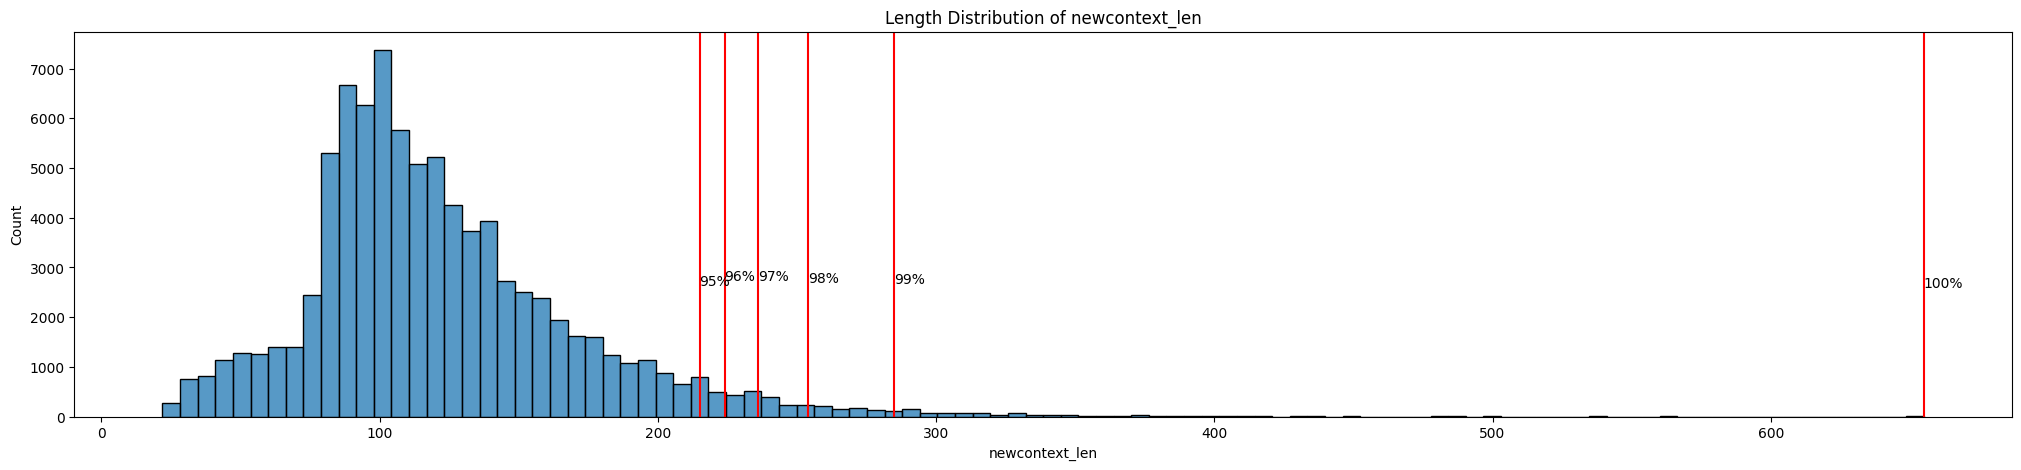

In [12]:
dist_info(df['newcontext_len'], (95,100))


In Order to Cover 100 percent of the data we need to create input length of 653 words which is too much. 

In [13]:
context_input_len = 1000 + 2 # +2 for <SOS> AND <EOS>

In [14]:
# Unique words in  context
# all_words = [i.split() for i in df['newcontext']]

## 2. Questions

In [15]:
df['question_len'].max()

25601

Percent  ::   words  

    95%  ::   17.0 words
    96%  ::   17.0 words
    97%  ::   18.0 words
    98%  ::   19.0 words
    99%  ::   21.0 words


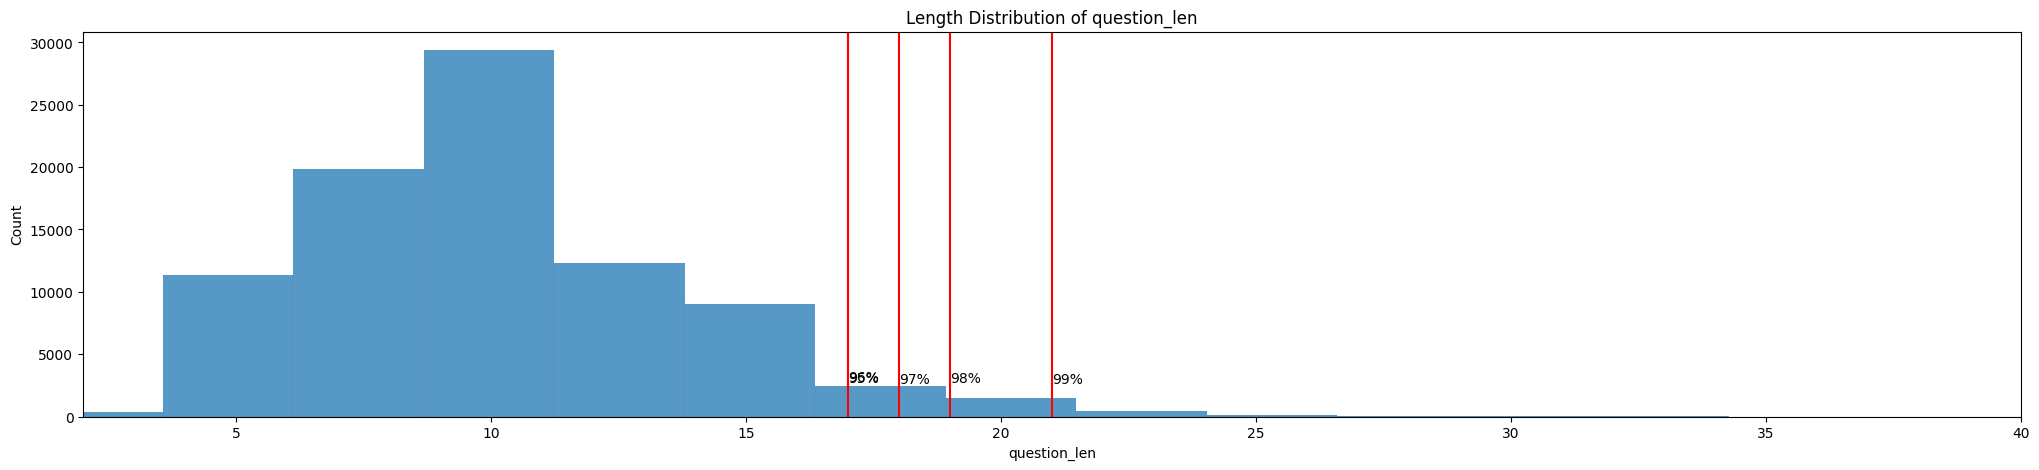

In [16]:
dist_info(x = df['question_len'], r = (95,99), xlim=[2,40], bins = 10000)

clearly there are too much bins 

Similar to context , for input for questions we would go with 50 words , it covers 99% data 

In [17]:
question_inputs_len = 50 + 2 # for <SOS> AND <EOS>

## 3. Answers

Percent  ::   words  

    95%  ::   10.0 words
    96%  ::   11.0 words
    97%  ::   13.0 words
    98%  ::   15.0 words
    99%  ::   18.0 words
   100%  ::   43.0 words


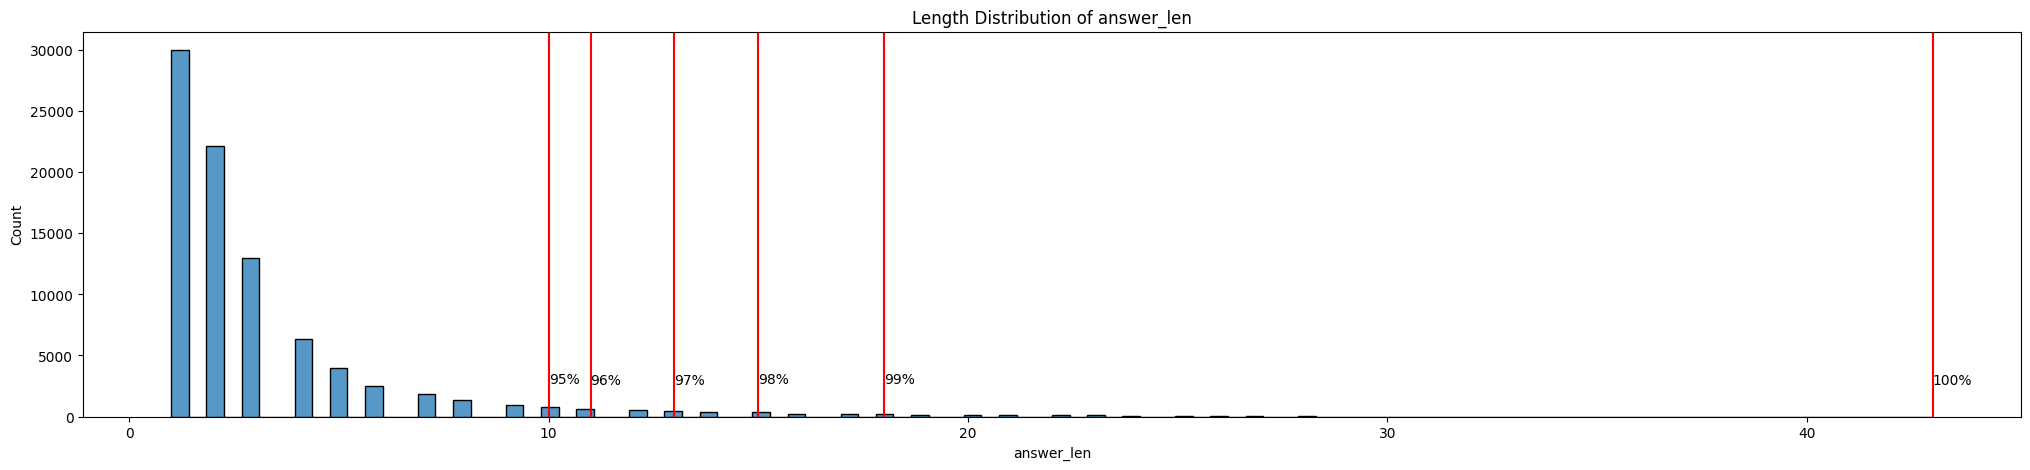

In [18]:
dist_info(df['answer_len'], (95,100))


Similar to context , for input for answers we would go with 50 words , it covers 100% data 

In [19]:
answer_inputs_len = 50 + 2 # for <SOS> AND <EOS>

# Preprocessing TEXT

In [20]:
# FUNCTIONS TO EXPAND CONTRACTIONS

with open('contractions.json') as f:
   contractions_dict = json.load(f)

def cont_to_exp(x):
    x = str(x).lower()
    xsplited = x.split(' ')
    exp_sentence = []
    for s in x.split():
        if s in contractions_dict.keys():
            
            s = contractions_dict.get(s)
        exp_sentence.append(s)
        
    x = ' '.join(exp_sentence)
    return x


In [21]:
# very necessary function you can't tell differece between "’" and "'", I don't even have that symbol in my keyboard
def text_cleaning_apos(text):
    text = str(text)
    text = text.lower()
    text = re.sub("’", "'", text) # removing punctuation
    text = cont_to_exp(text)
    text = re.sub('[#,@,&]', '',text)
    text = re.sub("'s",'', text)
    text = text.replace("?",' ?')
    text = text.replace(".",' .')
    text = text.replace("!",' !')
    text = text.replace(",",' ,')

    # text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    return text

In [22]:
# # func 1
# df = df.with_columns([
#     (pl.col("newcontext").apply(lambda x: text_cleaning_apos(x))),
#     (pl.col("questions").apply(lambda x: text_cleaning_apos(x))),
#     (pl.col("answer_text").apply(lambda x: text_cleaning_apos(x)))

# ])

In [23]:
df.head(5)

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,bool,i64,str,str,i64,str,i64,i64,i64,i64
0,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""When did Beyon...","""[{'text': 'in ...",false,1,"""{'text': 'in t...","""in the late 19...",269,"""Beyoncé Beyon...",109,111,6,4
1,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""What areas did...","""[{'text': 'sin...",false,1,"""{'text': 'sing...","""singing and da...",207,"""Beyoncé Beyon...",109,111,11,3
2,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""When did Beyon...","""[{'text': '200...",false,1,"""{'text': '2003...","""2003""",526,"""Beyoncé Beyon...",109,111,11,1
3,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""In what city a...","""[{'text': 'Hou...",false,1,"""{'text': 'Hous...","""Houston, Texas...",166,"""Beyoncé Beyon...",109,111,11,2
4,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""In which decad...","""[{'text': 'lat...",false,1,"""{'text': 'late...","""late 1990s""",276,"""Beyoncé Beyon...",109,111,7,2


In [24]:
# Adding start and end tokens 
'''
<soc>  : start of context
<eoc>  : end of context

<soq>  : start of questions
<eoq>  : end of questions

<soa>  : start of answer
<eoa>  : end of answer
'''
# df = df.with_columns([
#     ('<SOC> ' + pl.col('newcontext') + ' <EOC>').alias('newcontext'),
#     ('<SOQ> ' + pl.col('questions') + ' <EOQ>').alias('questions'),
#     ('<SOA> ' + pl.col('answer_text') + ' <EOA>').alias('answer_text'),    
# ])

'\n<soc>  : start of context\n<eoc>  : end of context\n\n<soq>  : start of questions\n<eoq>  : end of questions\n\n<soa>  : start of answer\n<eoa>  : end of answer\n'

In [25]:
df.head(5)

,title,context,ids,questions,answers,is_imposible,anslen,answers_clean,answer_text,answer_start,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,bool,i64,str,str,i64,str,i64,i64,i64,i64
0,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""When did Beyon...","""[{'text': 'in ...",false,1,"""{'text': 'in t...","""in the late 19...",269,"""Beyoncé Beyon...",109,111,6,4
1,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""What areas did...","""[{'text': 'sin...",false,1,"""{'text': 'sing...","""singing and da...",207,"""Beyoncé Beyon...",109,111,11,3
2,"""Beyoncé""","""Beyoncé Gisell...","""56be85543aeaaa...","""When did Beyon...","""[{'text': '200...",false,1,"""{'text': '2003...","""2003""",526,"""Beyoncé Beyon...",109,111,11,1
3,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""In what city a...","""[{'text': 'Hou...",false,1,"""{'text': 'Hous...","""Houston, Texas...",166,"""Beyoncé Beyon...",109,111,11,2
4,"""Beyoncé""","""Beyoncé Gisell...","""56bf6b0f3aeaaa...","""In which decad...","""[{'text': 'lat...",false,1,"""{'text': 'late...","""late 1990s""",276,"""Beyoncé Beyon...",109,111,7,2


# Vectorization

In [27]:
from tensorflow.keras.layers import TextVectorization, Embedding

In [166]:
# we will be using universal sentence encoder for vectorization and embedding
##download_USEncoder() # safety

In [167]:
# embed = hub.KerasLayer("./universal_sentence_encoder")

> **Note:** when using Univesal sentence encoder a == A but <a\> != a . This means `use` does not strip signs. GOOD NEWS

In [28]:

# Sentences = [
#     '<a>', 'a', 'A',            
#     "How <old> are you",
#     "What is your age",
#     "I love to watch Television",
#     "I am wearing a wrist watch"
# ]
# text_vectorizer = TextVectorization(max_tokens=30)
# text_vectorizer.adapt(Sentences)
# vect_layer = text_vectorizer(Sentences)
# print(vect_layer)

# embeddings = embed(Sentences)
  
# print('senetence embedding',embeddings)


# Preparing Dataset using `tf.data` api

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
xtrain , xtest, ytrain, ytest = train_test_split(df[['newcontext', 'questions']], df['answer_text'], test_size = .02, random_state = 5)
xtrain , xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = .02, random_state = 5)

In [31]:
print(f'Xtrain: {xtrain.shape} :: ytrain: {ytrain.shape}')
print(f'Xval:   {xval.shape}  :: yval: {yval.shape}')
print(f'Xtest:  {xtest.shape}  :: ytest: {ytest.shape}')

Xtrain: (83382, 2) :: ytrain: (83382,)
Xval:   (1702, 2)  :: yval: (1702,)
Xtest:  (1737, 2)  :: ytest: (1737,)


In [32]:
# Train data
train_feat = tf.data.Dataset.from_tensor_slices((xtrain['newcontext'].to_list(), xtrain['questions'].to_list()))
train_response = tf.data.Dataset.from_tensor_slices((ytrain))
train_data = tf.data.Dataset.zip((train_feat, train_response))

# Test data
test_feat = tf.data.Dataset.from_tensor_slices((xtest['newcontext'].to_list(), xtest['questions'].to_list()))
test_response = tf.data.Dataset.from_tensor_slices((ytest))
test_data = tf.data.Dataset.zip((test_feat, test_response))

# Val data
val_feat = tf.data.Dataset.from_tensor_slices((xval['newcontext'].to_list(), xval['questions'].to_list()))
val_response = tf.data.Dataset.from_tensor_slices((yval))
val_data = tf.data.Dataset.zip((val_feat, val_response))

2023-02-04 06:41:58.840905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 06:41:58.841372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 06:41:58.841642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 06:41:59.973252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 06:41:59.974347: I tensorflow/compiler/xla/stream_executo

In [33]:
# preprocessing text
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


In [48]:
sent = 'who is this?. '
print('sent: ', sent)
print('processed: ', tf_lower_and_split_punct(sent))

sent:  who is this?. 
processed:  tf.Tensor(b'[START] who is this ?  . [END]', shape=(), dtype=string)


In [34]:
for i in train_feat.take(1):
    print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b"Labour_Party_(UK)  Blair announced in September 2006 that he would quit as leader within the year, though he had been under pressure to quit earlier than May 2007 in order to get a new leader in place before the May elections which were expected to be disastrous for Labour. In the event, the party did lose power in Scotland to a minority Scottish National Party government at the 2007 elections and, shortly after this, Blair resigned as Prime Minister and was replaced by his Chancellor, Gordon Brown. Although the party experienced a brief rise in the polls after this, its popularity soon slumped to its lowest level since the days of Michael Foot. During May 2008, Labour suffered heavy defeats in the London mayoral election, local elections and the loss in the Crewe and Nantwich by-election, culminating in the party registering its worst ever opinion poll result since records began in 1943, of 23%, with many citing Brown's leadership as a key 

In [35]:
BATCH_SIZE = 32

# prefetching 
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [36]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


# Vectorization

In [37]:
from tensorflow.keras.layers import TextVectorization

In [38]:
# MAX_TOKENS = 10_000
OUTPUT_SEQUENCE_LENGTH = 2_000

In [40]:
vectorizer = TextVectorization( standardize = tf_lower_and_split_punct, output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
                                # pad_to_max_tokens = True
                              )

In [41]:
# %%timeit
# takes 1.30 minutes
vectorizer.adapt(train_feat)

In [42]:
sent = 'what is my name? beyonce'

In [43]:
vectorizer(sent)

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([10, 22, 12, ...,  0,  0,  0])>

In [44]:
print('Total vectorized words:',len(vectorizer.get_vocabulary()))

Total vectorized words: 89879


In [45]:
from tensorflow.keras.layers import StringLookup

In [46]:
# Lookup table to convert strings to indices and vice versa 
str_to_idx = StringLookup(vocabulary=vectorizer.get_vocabulary(), oov_token='[UNK]')    
idx_to_str = StringLookup(vocabulary=vectorizer.get_vocabulary(), oov_token='[UNK2]', invert = True)    

In [47]:
aa = str_to_idx(sent.split(' '))
print(aa)
aa = idx_to_str(aa)
print(aa)

tf.Tensor([  23   13 1573    0  335], shape=(5,), dtype=int64)
tf.Tensor([b'what' b'is' b'my' b'[UNK2]' b'beyonce'], shape=(5,), dtype=string)


# Model

In [ ]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                             f"    found: {new_dim}\n"
                             f"    expected: {old_dim}\n")

In [62]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [63]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)


In [64]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)
        
    @Decoder.add_method
    def call(self,
         context, x,
         state=None,
         return_state=False):  
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch t')
        shape_checker(context, 'batch s units')

        # 1. Lookup the embeddings
        x = self.embedding(x)
        shape_checker(x, 'batch t units')

        # 2. Process the target sequence.
        x, state = self.rnn(x, initial_state=state)
        shape_checker(x, 'batch t units')

        # 3. Use the RNN output as the query for the attention over the context.
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights
        shape_checker(x, 'batch t units')
        shape_checker(self.last_attention_weights, 'batch t s')

        # Step 4. Generate logit predictions for the next token.
        logits = self.output_layer(x)
        shape_checker(logits, 'batch t target_vocab_size')

        if return_state:
            return logits, state
        else:
            return logits
        
    @Decoder.add_method
    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]
    
    
    @Decoder.add_method
    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result
    
    @Decoder.add_method
    def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (next_token == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state

In [65]:
class Model(tf.keras.Model):

    def __init__(self, vectorizer, UNITS = 32,  EMBEDDING_DIMS = 32):
        super().__init__()
        self.vectorizer = vectorizer 
        self.UNITS = UNITS

        # Build the encoder and decoder
        encoder = Encoder(vectorizer, UNITS)
        decoder = Decoder(vectorizer, UNITS)

        self.encoder = encoder
        self.decoder = decoder

    # class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def call(self, inputs):
        context,question, x = inputs
        context = self.encoder(context)
        question = self.encoder(question)
        context_and_questions = tf.keras.layers.concatenate([context, question])
        logits = self.decoder(context_and_questions, x)

        #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits


In [66]:
vectorizer.vocabulary_size()

89879

In [67]:
UNITS = 32

model = Model(UNITS, vectorizer)

logits = model(train_data)


AttributeError: 'int' object has no attribute 'vocabulary_size'

In [184]:
UNITS = 32
output_dim =512 # universal sentence encoder embeddes is 512 many dimensions

# Define the encoder
encoder_inputs = Input(shape = [], dtype = tf.string, name= 'context_inputs')
print(encoder_inputs.shape)
embed_layer1 = embed(encoder_inputs)
embed_layer1 = tf.expand_dims(embed_layer1, axis = 1)

print(embed_layer1.shape)
encoder = LSTM(UNITS, return_state=True)

encoder_outputs, state_h, state_c = encoder(embed_layer1)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape = [], dtype = tf.string, name= 'question_inputs')
embed_layer2 = embed(decoder_inputs)
embed_layer2 = tf.expand_dims(embed_layer2, axis = 1)


decoder_lstm = LSTM( UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(embed_layer2, initial_state=encoder_states)
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(attention)

# Define the model
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile and fit the model
model.compile(optimizer='adam', loss='categorical_crossentropy')


(None,)
(None, 1, 512)


In [185]:
EPOCHS = 2

In [186]:
# model.fit(train_data, epochs=EPOCHS)